In [81]:
import numpy as np
import pandas as pd
import gc
import datetime

from sklearn.model_selection import KFold
import lightgbm as lgb

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

NFOLD = 5
DATA_PATH = './'

In [82]:
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")

train.drop(['per_square_meter_price'], axis=1, inplace=True)

train['target'] = 1
train[train['price_type'] == 0]['target'] = 1
train[train['price_type'] == 1]['target'] = 0
test['target'] = 0

n_train = train.shape[0]
df = pd.concat([train, test], axis = 0)
df.drop(['date'], axis=1, inplace=True)
df.drop(['price_type'], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
del train, test
gc.collect()

192

In [84]:
predictors = list(df.columns.difference(['id', 'target']))
df_train = df.iloc[:n_train].copy()
cols_to_remove = [c for c in predictors if df_train[c].nunique() == 1]
df.drop(cols_to_remove, axis=1, inplace=True)

In [85]:
# Shuffle dataset
df = df.iloc[np.random.permutation(len(df))]
df.reset_index(drop=True, inplace=True)

# Get target column name
target = 'target'

# lgb params
lgb_params = {
        'boosting': 'gbdt',
        'application': 'binary',
        'metric': 'auc', 
        'learning_rate': 0.001 ,
        'num_leaves': 70,
        'max_depth': 8,
        'min_data_in_leaf': 21,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'feature_fraction': 0.9,
        'is_unbalance': True, 
} 

# Get folds for k-fold CV
folds = KFold(n_splits = NFOLD, shuffle = True, random_state = 0)
fold = folds.split(df)
    
eval_score = 0
n_estimators = 0
eval_preds = np.zeros(df.shape[0])

In [86]:
data_numeric = df.select_dtypes(exclude=['object'])
data_obj = df.select_dtypes(include=['object']).copy()

In [87]:
for c in data_obj:
    data_obj[c] = pd.factorize(data_obj[c])[0]

In [88]:
df = pd.concat([data_numeric, data_obj], axis=1)
y = df['target'];

In [89]:
for i, (train_index, test_index) in enumerate(fold):
    print( "\n[{}] Fold {} of {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i+1, NFOLD))
    train_X, valid_X = df[predictors].values[train_index], df[predictors].values[test_index]
    train_y, valid_y = df[target].values[train_index], df[target].values[test_index]

    dtrain = lgb.Dataset(train_X, label = train_y,
                          feature_name = list(predictors)
                          )
    
    dvalid = lgb.Dataset(valid_X, label = valid_y,
                          feature_name = list(predictors)
                          )
        
    eval_results = {}
    
    bst = lgb.train(lgb_params, 
                         dtrain, 
                         valid_sets = [dtrain, dvalid], 
                         valid_names = ['train', 'valid'], 
                         evals_result = eval_results, 
                         num_boost_round = 5000,
                         early_stopping_rounds = 100,
                         verbose_eval = 100)
    
    print("\nRounds:", bst.best_iteration)
    print("AUC: ", eval_results['valid']['auc'][bst.best_iteration-1])

    n_estimators += bst.best_iteration
    eval_score += eval_results['valid']['auc'][bst.best_iteration-1]
   
    eval_preds[test_index] += bst.predict(valid_X, num_iteration = bst.best_iteration)
    
n_estimators = int(round(n_estimators/NFOLD,0))
eval_score = round(eval_score/NFOLD,6)

print("\nModel Report")
print("Rounds: ", n_estimators)
print("AUC: ", eval_score)    


[2021-09-25 12:18:30] Fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.986389	valid's auc: 0.975699
[200]	train's auc: 0.988425	valid's auc: 0.977145
[300]	train's auc: 0.989934	valid's auc: 0.97799
[400]	train's auc: 0.991312	valid's auc: 0.979079
[500]	train's auc: 0.992492	valid's auc: 0.979779
[600]	train's auc: 0.993537	valid's auc: 0.980039
[700]	train's auc: 0.99451	valid's auc: 0.980172
[800]	train's auc: 0.995486	valid's auc: 0.9803
[900]	train's auc: 0.996318	valid's auc: 0.980409
[1000]	train's auc: 0.996948	valid's auc: 0.980459
[1100]	train's auc: 0.99742	valid's auc: 0.980507
[1200]	train's auc: 0.997815	valid's auc: 0.980428
Early stopping, best iteration is:
[1113]	train's auc: 0.997483	valid's auc: 0.980521

Rounds: 1113
AUC:  0.9805210304190003

[2021-09-25 12:20:48] Fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.986422	valid's auc: 0.976512
[200]	train's auc: 0.988426	val

<Figure size 1080x576 with 0 Axes>

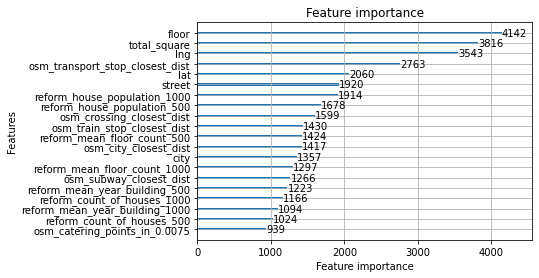

In [92]:
plt.figure(figsize=(15, 8))
lgb.plot_importance(bst, max_num_features=20)

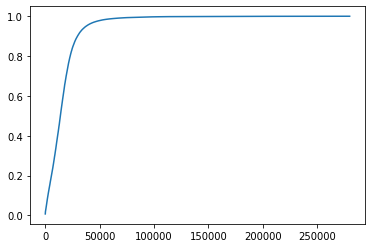

In [93]:
df_av = df[['id', 'target']].copy()
df_av['preds'] = eval_preds
df_av_train = df_av[df_av.target == 1]
df_av_train = df_av_train.sort_values(by=['preds']).reset_index(drop=True)

# Check distribution
df_av_train.preds.plot()

# Store to feather
df_av_train[['id', 'preds']].reset_index(drop=True).to_feather('adversarial_validation.ft')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


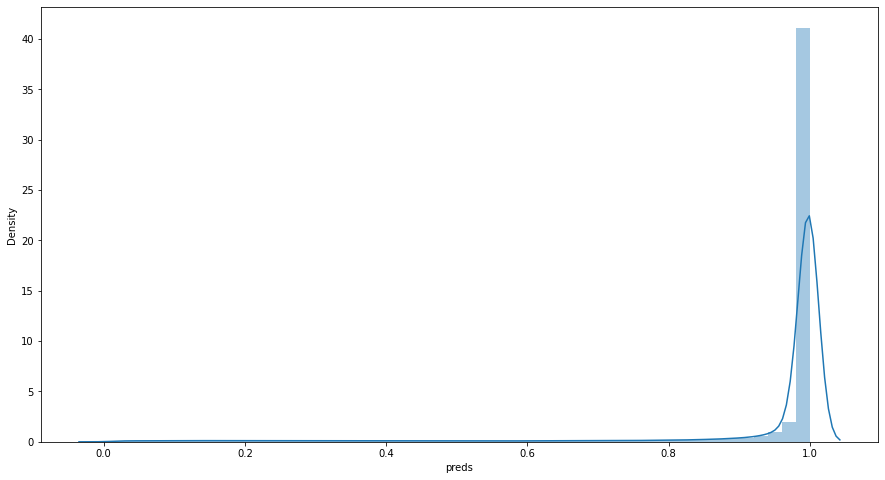

In [94]:
plt.figure(figsize=(15, 8))
sns.distplot(df_av_train['preds'])

In [100]:
for th in [0.6, 0.7, 0.8]:
    print(f"Количество объектов трейна, которые модель слабо отличает от теста при пороге == {th}: {df_av_train[df_av_train['preds'] < th].shape[0]}")

Количество объектов трейна, которые модель слабо отличает от теста при пороге == 0.6: 16373
Количество объектов трейна, которые модель слабо отличает от теста при пороге == 0.7: 19190
Количество объектов трейна, которые модель слабо отличает от теста при пороге == 0.8: 22893
